<a href="https://colab.research.google.com/github/ReemaHariry/Transformers/blob/main/spamORham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [13]:
!pip install transformers datasets evaluate -q


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset,DatasetDict ,Dataset
from transformers import AutoTokenizer ,AutoModelForSequenceClassification , TrainingArguments ,Trainer
import evaluate
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import torch


# Analysis

In [15]:
dataset = load_dataset("FredZhang7/all-scam-spam")
print(f"Dataset structure: {dataset}")

df = dataset["train"].to_pandas()
df.head(10)


Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'is_spam'],
        num_rows: 42619
    })
})


,text,is_spam
0,Re: New Sequences Window\n\n Date: W...,0
1,[zzzzteana] RE: Alexander\n\nMartin A posted:\...,0
2,[zzzzteana] Moscow bomber\n\nMan Threatens Exp...,0
3,[IRR] Klez: The Virus That Won't Die\n\nKlez:...,0
4,Re: [zzzzteana] Nothing like mama used to make...,0
5,Re: [zzzzteana] Nothing like mama used to make...,0
6,[zzzzteana] Playboy wants to go out with a ban...,0
7,Re: [zzzzteana] Nothing like mama used to make...,0
8,[zzzzteana] Meaningful sentences\n\nThe Scotsm...,0
9,[SAtalk] SA CGI Configurator Scripts\n\nI have...,0


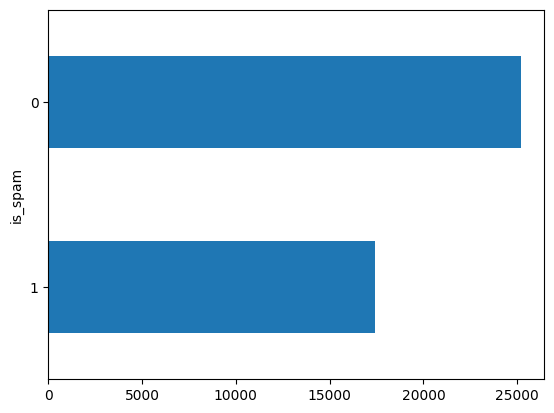

In [16]:
#is_spam=1 means spam and is_spam=0 means ham.
label_counts = df['is_spam'].value_counts(ascending=True)
label_counts.plot.barh()
plt.show()


# Words_embedding --> Tokenize

In [17]:
MODELS = {
    'tiny': {
        'model_name': 'prajjwal1/bert-tiny',
        'max_length': 128,
        'batch_size': 32,
        'learning_rate': 2e-5,
        'epochs': 3
    },
    'base': {
        'model_name': 'bert-base-uncased',
        'max_length': 512,
        'batch_size': 16,
        'learning_rate': 2e-5,
        'epochs': 2
    },
    'large': {
        'model_name': 'bert-large-uncased',
        'max_length': 512,
        'batch_size': 8,
        'learning_rate': 1e-5,
        'epochs': 2
    }
}

for model_type, config in MODELS.items():
    print(f"{model_type.upper()}: {config['model_name']}")

TINY: prajjwal1/bert-tiny
BASE: bert-base-uncased
LARGE: bert-large-uncased


In [18]:
def tokenize_function(examples, tokenizer, max_length):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )


## Split the dataset to Train/Test


In [19]:
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 34095
Testing samples: 8524


In [20]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Training And Evaluating each model

In [29]:
def train_models (model_type,config):
    print(f"Training {model_type.upper()} model")

    #loading the tokenzer and model
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    model = AutoModelForSequenceClassification.from_pretrained(
        config['model_name'],
        num_labels=2
    )

    #then we will start tokenizing to have vector
    train_tokenized = train_dataset.map(
        lambda x: tokenize_function(x, tokenizer, config['max_length']),
        batched=True
    )
    test_tokenized = test_dataset.map(
        lambda x: tokenize_function(x, tokenizer, config['max_length']),
        batched=True
    )

    train_tokenized = train_tokenized.rename_column("is_spam", "labels")
    test_tokenized = test_tokenized.rename_column("is_spam", "labels")

    training_args = TrainingArguments(
      output_dir="./results_{model_type}",
      eval_strategy="epoch",
      save_strategy="epoch",
      learning_rate=config['learning_rate'],
      per_device_train_batch_size=config['batch_size'],
      per_device_eval_batch_size=config['batch_size'],
      num_train_epochs=config['epochs'],
      weight_decay=0.01,
      logging_dir="./logs_{model_type}",
      logging_steps=100,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy",
      greater_is_better=True,
      report_to="none",
    )

    os.environ["WANDB_DISABLED"] = "true"

    trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_tokenized,
      eval_dataset=test_tokenized,
      compute_metrics=compute_metrics,
    )

    print(f"training {model_type} model...")
    trainer.train()

    print(f"Evaluating {model_type} model...")
    eval_results = trainer.evaluate()

    return trainer, eval_results, tokenizer

# Training Model

In [27]:
model_results = {}
trained_models = {}

### **Tiny model**

In [30]:
tiny_trainer, tiny_results, tiny_tokenizer = train_models('tiny', MODELS['tiny'])
model_results['tiny'] = tiny_results
trained_models['tiny'] = {
    'trainer': tiny_trainer,
    'tokenizer': tiny_tokenizer,
    'model': tiny_trainer.model
}

Training TINY model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training tiny model...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.212700,0.186271,0.937119
2,0.165400,0.141292,0.951197
3,0.134500,0.133023,0.955537


Evaluating tiny model...


## **Base model**

In [ ]:
base_trainer, base_results, base_tokenizer = train_models('base', MODELS['base'])
model_results['base'] = base_results
trained_models['base'] = {
    'trainer': base_trainer,
    'tokenizer': base_tokenizer,
    'model': base_trainer.model
}

Training BASE model


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34095 [00:00<?, ? examples/s]

Map:   0%|          | 0/8524 [00:00<?, ? examples/s]

training base model...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.059000,0.049717,0.985922


## **Large Model**

In [ ]:
large_trainer, large_results, large_tokenizer = train_models('large', MODELS['large'])
model_results['large'] = large_results
trained_models['large'] = {
    'trainer': large_trainer,
    'tokenizer': large_tokenizer,
    'model': large_trainer.model
}


# Testing

In [ ]:
test_examples = [
    "Congratulations! You've won $1000! Click here to claim your prize now!",
    "Hey, can you send me the meeting notes from yesterday?",
    "URGENT: Your account will be suspended. Verify your information immediately!",
    "Thanks for the great presentation today. Looking forward to our next meeting.",
    "Free money! No strings attached! Get rich quick scheme!",
    "The project deadline has been moved to next Friday. Please update your schedule."
]

def predict_spam(model_type, text, trained_models):
    model_info = trained_models[model_type]
    tokenizer = model_info['tokenizer']
    model = model_info['model']

    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True,
                      max_length=MODELS[model_type]['max_length'])

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        spam_prob = predictions[0][1].item()
        ham_prob = predictions[0][0].item()

    return {
        'spam_probability': spam_prob,
        'ham_probability': ham_prob,
        'prediction': 'SPAM' if spam_prob > 0.5 else 'HAM',
        'confidence': max(spam_prob, ham_prob)
    }

print("\nTesting all models on sample texts:")

for i, text in enumerate(test_examples, 1):
    print(f"\nExample {i}: {text}")

    for model_type in ['tiny', 'base', 'large']:
        result = predict_spam(model_type, text, trained_models)
        print(f"{model_type.upper():>5}: {result['prediction']:>4} "
              f"(Spam: {result['spam_probability']:.3f}, "
              f"Confidence: {result['confidence']:.3f})")

# Comparison